In [1]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split

raw_data_path = './data/dataset/short_victorian.csv'
destination_folder = './processed_data'

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

def label_gen(df):
    num_authors = 50
    label = num_authors * [0]
    label[df['author']-1] = 1
    return label

#tokenization
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [2]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['label'] = df_raw['author']
df_raw = df_raw.drop(['author'], axis=1)
df_raw = df_raw.reindex(columns=['label', 'text'])

# Train-test split
full_train_set, df_test = train_test_split(df_raw, train_size = train_test_ratio, random_state = 1)
# Train-valid split
df_train, df_valid = train_test_split(full_train_set, train_size = train_valid_ratio, random_state = 1)

df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [3]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator

# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

source_folder = './processed_data'
destination_folder = './nn_model'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [6]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [7]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [8]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [9]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

., 18., 41., 19., 21., 45., 33., 48., 40., 45., 42.,
        17., 27.,  8., 14.])
tensor([ 8., 12.,  8., 30.,  8., 37., 45., 14., 37., 26., 38., 48., 38.,  8.,
         8., 14., 23., 36., 26., 19., 45., 48., 14.,  8.,  8., 38., 50., 21.,
        10., 19., 14., 48.])
tensor([50., 26., 25., 37., 19.,  1., 35., 18., 19.,  1., 19., 37., 48., 33.,
        37., 14., 48., 34.,  8., 45., 38., 39., 26., 18.,  8.,  4., 15., 43.,
        15., 17., 26., 48.])
tensor([26., 38., 39., 26., 19., 35.,  8., 39., 37., 42., 26., 12., 17.,  2.,
        48., 42., 18., 25., 33., 38., 48., 28., 44., 37., 14., 21.,  8.,  8.,
        26.,  1.,  9., 12.])
tensor([48.,  8., 37., 45.,  8., 24., 26., 26., 19., 26., 50., 14., 13.,  3.,
        26., 26., 39., 48.,  4., 14., 30., 21., 41., 29., 33., 26., 29., 34.,
         8., 45.,  8., 37.])
tensor([30., 21., 19., 10., 12., 21., 26., 38., 41.,  1., 33., 26., 44., 33.,
        38., 25., 33.,  3.,  3., 21., 12., 30., 40.,  1., 26., 37., 33.,  8.,
         8., 26.,  8.,

Model loaded from <== ./nn_model/metrics.pt


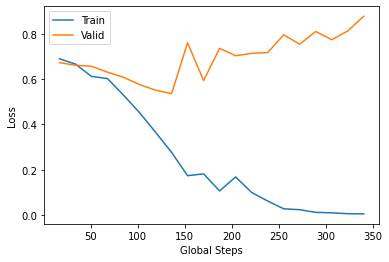

In [42]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [45]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    # print('Classification Report:')
    # print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    # cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    # ax= plt.subplot()
    # sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    # ax.set_title('Confusion Matrix')

    # ax.set_xlabel('Predicted Labels')
    # ax.set_ylabel('EAP Labels')

    # ax.xaxis.set_ticklabels(['MWS', 'EAP'])
    # ax.yaxis.set_ticklabels(['MWS', 'EAP'])

Model loaded from <== ./nn_model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6902    0.6875    0.6888      5440
           0     0.7616    0.7639    0.7627      7110

    accuracy                         0.7308     12550
   macro avg     0.7259    0.7257    0.7258     12550
weighted avg     0.7306    0.7308    0.7307     12550



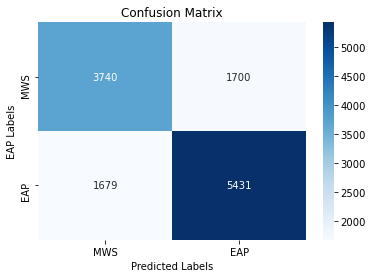

In [46]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)